In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.expanduser(os.path.join('~','Documents', 'projects', 'coronavirus')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src.tools as tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import scipy.integrate as integrate
from src.data_downloader import DATA_REPOS, download_from_repo

### update data from repos

In [3]:
dest='/home/maurizio/Documents/projects/coronavirus/data'

In [4]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['deaths'], dest=dest)
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['confirmed'], dest=dest)
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['recovered'], dest=dest)
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['andamento-nazionale'], dest=dest)
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['regioni'], dest=dest)
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['province'], dest=dest)

last commit  2020-03-23 19:23:43
last commit  2020-03-23 19:23:43
last commit  2020-03-23 19:23:43
last commit  2020-03-23 19:27:30
last commit  2020-03-23 19:27:30
last commit  2020-03-23 19:27:30


## SIRD Model definition

In [2]:
# SIR model differential equations
def SIR_deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SIR_deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


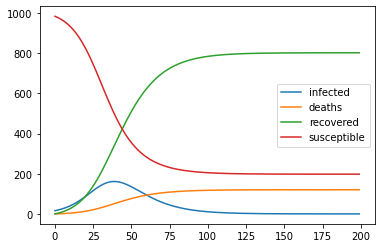

In [3]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  2.253830292607903
gamma:  2.0406574433035156
theta:  0.002398249314765765
r0:  1.103166350653664
mean period of time of infection:  0.49003815083297436
max number of infections  280929.33035130723
max number of deaths  13018.728349252508
mae  40.033591340194896


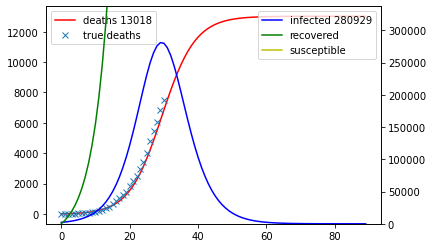

In [4]:
use_differential_evolution = True
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(-5,5), (-5, 5), (-5, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/(params[1]+params[2]))
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots()
ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()

## SEIR Model definition

In [5]:
def SEIRModel(t, S0, E0, I0, R0, r0, dur_inf, dur_inc):
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt
    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over time t
    ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
    S, E, I, R = ret.T
    return S, E, I, R

def calibrate_SEIR(y_fit,
                   N,
                   I0,
                   R0 = 0,
                   E0 = 0,
                   CFR = 0.02,
                   time_horizon = 365,
                   bounds= [(0,5), (1, 30), (1, 30)],
                   use_differential_evolution = True):
    
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    def SEIRModel_solver(t, r0, dur_inf, dur_inc):
        # Initial conditions vector
        y0 = S0, E0, I0, R0
        # Integrate the SIR equations over time t
        ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
        S, E, I, R = ret.T
        return I

    def diff_ev_solver(params):
        r0, dur_inf, dur_inc = params
        return np.mean(np.abs(SEIRModel_solver(x_fit, r0, dur_inf, dur_inc) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0 = N - I0 - R0 - E0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(diff_ev_solver, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        lo_bound = []
        up_bound = []
        for bound in bounds:
            lo_bound.append(bound[0])
            up_bound.append(bound[1])
        params, _ = curve_fit(f=SEIRModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=(lo_bound, up_bound))
    r0, dur_inf, dur_inc = params
    
    total_deaths = integrate.quad(lambda x: CFR*SEIRModel((x,), S0, E0, I0, R0, r0, dur_inf, dur_inc)[2], 0, time_horizon)[0]

    print('total deaths', total_deaths)
    print('r0', params[0])
    print('infection period in days', params[1])
    print('incubation period in days', params[2])
    print('mae ',int(np.mean(np.abs(y_fit-SEIRModel_solver(x_fit, *params)))))
    return r0, dur_inf, dur_inc

def plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y = None):
    
    S0 = N - I0 - R0 - E0
    S, E, I, R = SEIRModel(time_range, S0, E0, I0, R0, r0, dur_inf, dur_inc)
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    
    fig, ax1 = plt.subplots()
    if y is not None:
        ax1.plot(y,'x', label='actual infected')
    ax1.plot(I,'b', label='infected - max '+str(int(np.max(I))))
    #ax1.plot(R,'g', label='recovered')
    #x1.plot(E,'y', label='exposed')
    ax1.legend(loc='upper left')

    

### check model params

max number of infections  62723
peak of infections  72
max number of exposed  115138
max number of recovered  798206


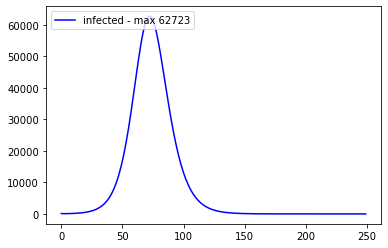

In [6]:
N = 946002
I0 = 117
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = (2.2, 2.9, 5.2)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc)

### calibrate to italian case

calibrating with genetic algorithm...
total deaths 16133.000000000002
r0 4.898398766265018
infection period in days 15.90266788032698
incubation period in days 1.0012878815670778
mae  51594
max number of infections  27311772
peak of infections  60
max number of exposed  2941128
max number of recovered  61356692


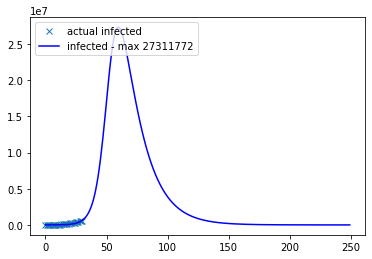

In [7]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230# 60431283
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = cases_multiplier * df['totale_attualmente_positivi'].values
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = calibrate_SEIR(y_fit = y_fit,               
                                      N = N,
                                      I0 = I0,
                                      R0 = R0,
                                      E0 = E0,
                                      CFR = 0.02,
                                      time_horizon = 365,
                                      bounds= [(0,5), (1, 30), (1, 30)],
                                      use_differential_evolution = True)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y_fit)

## SEIRD Model definition

In [8]:
def SEIRDModel(t, S0, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta):
    # SEIR model differential equations
    def SEIRD_deriv(y, t, r0, dur_inf, dur_inc, theta):
        S, E, I, R, D = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * (gamma)# + theta)
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I - theta * I
        dRdt = gamma * I * (1 - theta)
        dDdt = theta * I
        return dSdt, dEdt, dIdt, dRdt, dDdt
    # Initial conditions vector
    y0 = S0, E0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SEIRD_deriv, y0, t, args=(r0, dur_inf, dur_inc, theta))
    S, E, I, R, D = ret.T
    return S, E, I, R, D

def calibrate_SEIRD(y_fit,
                   N,
                   I0,
                   R0 = 0,
                   E0 = 0,
                   D0 = 0,                   
                   time_horizon = 365,
                   bounds= [(0,5), (1, 30), (1, 30), (0,1.)],
                   use_differential_evolution = True):
    
    # SEIR model differential equations
    def SEIRD_deriv(y, t, r0, dur_inf, dur_inc, theta):
        S, E, I, R, D = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * (gamma + theta)
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I - theta * I
        dRdt = gamma * I
        dDdt = theta * I
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def SEIRDModel_solver(t, r0, dur_inf, dur_inc, theta):
        # Initial conditions vector
        y0 = S0, E0, I0, R0, D0
        # Integrate the SIR equations over time t
        ret = odeint(SEIRD_deriv, y0, t, args=(r0, dur_inf, dur_inc, theta))
        S, E, I, R, D = ret.T
        return D

    def diff_ev_solver(params):
        r0, dur_inf, dur_inc, theta = params
        return np.mean(np.abs(SEIRDModel_solver(x_fit, r0, dur_inf, dur_inc, theta) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0 = N - I0 - R0 - E0 - D0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(diff_ev_solver, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        lo_bound = []
        up_bound = []
        for bound in bounds:
            lo_bound.append(bound[0])
            up_bound.append(bound[1])
        params, _ = curve_fit(f=SEIRDModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=(lo_bound, up_bound))
    r0, dur_inf, dur_inc, theta = params
    
    #total_deaths = integrate.quad(lambda x: CFR*SEIRModel((x,), S0, E0, I0, R0, r0, dur_inf, dur_inc)[2], 0, 250)[0]

    print('CFR ', theta)
    print('r0', params[0])
    print('infection period in days', params[1])
    print('incubation period in days', params[2])
    print('mae ',int(np.mean(np.abs(y_fit-SEIRDModel_solver(x_fit, *params)))))
    return r0, dur_inf, dur_inc, theta

def plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta, y = None):
    
    S0 = N - I0 - R0 - E0 - D0
    S, E, I, R, D = SEIRDModel(time_range, S0, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta)
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    print('max number of deaths ', int(np.max(D)))
    
    fig, ax1 = plt.subplots()
    if y is not None:
        ax1.plot(y,'x', label='actual infected')
    ax1.plot(I,'b', label='infected - max '+str(int(np.max(I))))
    ax1.plot(D,'r', label='deaths')
    #x1.plot(E,'y', label='exposed')
    ax1.legend(loc='upper left')

    

### check model params

max number of infections  2658753
peak of infections  129
max number of exposed  4681103
max number of recovered  42354784
max number of deaths  2328438


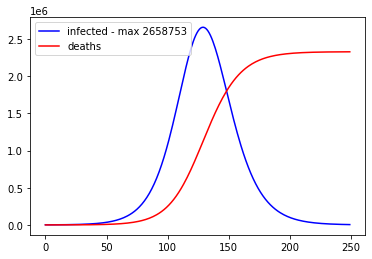

In [9]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230
I0 = 2209
R0 = 0
E0 = 0
D0 = 0
time_range = range(250)
r0, dur_inf, dur_inc, theta = (1.9, 3.61, 5.95, 0.015)
plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta)

### calibrate to italian case

CFR  0.03689147145186059
r0 3.809912195462413
infection period in days 1.1559197790277598
incubation period in days 15.883844676322836
mae  170
max number of infections  1495478
peak of infections  75
max number of exposed  21484318
max number of recovered  55474358
max number of deaths  2456239


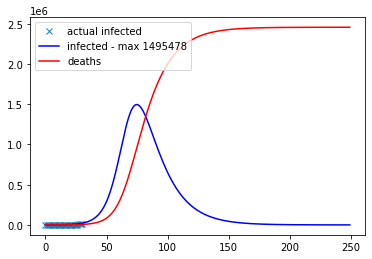

In [10]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230# 60431283
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = df['deceduti'].values
R0 = 0
E0 = 0
D0 = 0
time_range = range(250)
r0, dur_inf, dur_inc, theta = calibrate_SEIRD(y_fit = y_fit,               
                                      N = N,
                                      I0 = I0,
                                      R0 = R0,
                                      E0 = E0,
                                      D0 = D0,
                                      time_horizon = 365,
                                      bounds= [(0,5), (1, 30), (1, 30), (0,1)],
                                      use_differential_evolution = False)
plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta, y_fit)

In [161]:
def func(y, t, N, I0, R0, D_incubation, D_infectious, D_recovery_mild, 
         D_hospital_lag, D_recovery_severe, D_death, P_SEVERE, CFR, 
         InterventionTime, InterventionAmt, duration):
    
    interpolation_steps = 40
    steps = 110*interpolation_steps
    dt = dt/interpolation_steps
    sample_step = interpolation_steps
# SEIR ODE
    if (t > InterventionTime & t < InterventionTime + duration):
        beta = (InterventionAmt)*R0/(D_infectious)
    elif(t > InterventionTime + duration):
        beta = 0.5*R0/(D_infectious)        
    else:
        beta = R0/(D_infectious)

    a     = 1/D_incubation
    gamma = 1/D_infectious

    S         = y[0] # Susectable
    E         = y[1] # Exposed
    I         = y[2] # Infectious 
    Mild      = y[3] # Recovering (Mild)     
    Severe    = y[4] # Recovering (Severe at home)
    Severe_H  = y[5] # Recovering (Severe in hospital)
    Fatal     = y[6] # Recovering (Fatal)
    R_Mild    = y[7] # Recovered
    R_Severe  = y[8] # Recovered
    R_Fatal   = y[9] # Dead
    p_severe  = P_SEVERE
    p_fatal   = CFR
    p_mild    = 1 - P_SEVERE - CFR
    dS        = -beta*I*S
    dE        =  beta*I*S - a*E
    dI        =  a*E - gamma*I
    dMild     =  p_mild*gamma*I   - (1/D_recovery_mild)*Mild
    dSevere   =  p_severe*gamma*I - (1/D_hospital_lag)*Severe
    dSevere_H =  (1/D_hospital_lag)*Severe - (1/D_recovery_severe)*Severe_H
    dFatal    =  p_fatal*gamma*I  - (1/D_death)*Fatal
    dR_Mild   =  (1/D_recovery_mild)*Mild
    dR_Severe =  (1/D_recovery_severe)*Severe_H
    dR_Fatal  =  (1/D_death)*Fatal
    
    return dS, dE, dI, dMild, dSevere, dSevere_H, dFatal, dR_Mild, dR_Severe, dR_Fatal

In [23]:
#https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

In [28]:
# Define parameters
t_max = 100
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2
beta = 1.75
gamma = 0.5
params = alpha, beta, gamma
# Run simulation
results = base_seir_model(init_vals, params, t)

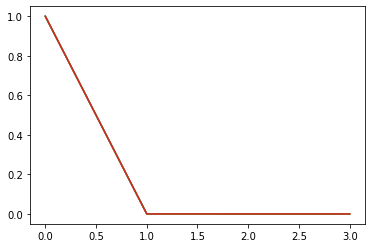

In [29]:
plt.plot(results[0], label='S')
plt.plot(results[1], label='E')
plt.plot(results[2], label='I')
plt.plot(results[3], label='R')